In [1]:
import os
os.chdir("/home/jovyan/work/26_Types_of_Balls-Image_Classification")
!pwd

/home/jovyan/work/26_Types_of_Balls-Image_Classification


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import utils

In [3]:
# physical_gpus = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_gpus[0], True)

# Start

In [4]:
original_model = load_model("dataset/EfficientNetB3-balls-99.23.h5")

In [5]:
balls_data = pd.read_csv("dataset/balls.csv")
train_num = len(balls_data[balls_data["data set"]=="train"])
train_num

3051

In [6]:
train_dir = "dataset/train"
val_dir = "dataset/valid"
test_dir = "dataset/test"

ImageDataGenerator詳細：https://zhuanlan.zhihu.com/p/30197320

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=360,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=300, class_mode="categorical", target_size=(128, 128))
validation_generator = val_datagen.flow_from_directory(val_dir, batch_size=100, class_mode="categorical", target_size=(128, 128))

Found 3051 images belonging to 26 classes.
Found 130 images belonging to 26 classes.


如何去掉模型的全連接層：https://blog.csdn.net/qq_29462849/article/details/83010854

In [8]:
base_model = keras.Model(
    inputs=original_model.input,
    outputs=original_model.get_layer("batch_normalization").output,
    trainable=False
)
model = keras.Sequential([
    base_model,
    layers.Dense(1024, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(512, activation="relu", kernel_initializer="he_normal"),
    # layers.Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(26, activation="softmax")
])
model.summary()
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1536)              10789679  
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 26)                6682      
Total params: 13,026,377
Trainable params: 2,236,698
Non-trainable params: 10,789,679
_________________________________________________________________


ReduceLROnPlateau待測試：https://hackmd.io/@allen108108/SyCsOIkxB

In [9]:
model_tag = 'model_1'
models_dir = 'models'
model_dir = os.path.join(models_dir, model_tag)
callbacks = []
''' EarlyStopping '''
callbacks.append(
    keras.callbacks.EarlyStopping(monitor="loss", patience=100, verbose=1, mode="auto")
)
''' ModelCheckpoint '''
model_name = 'model.h5'
filepath = os.path.join(model_dir, model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' ModelCheckpoint '''
model_name = 'epoch_{epoch:03d}-val_loss_{val_loss:.3f}.h5'
filepath = os.path.join(model_dir, "checkpoint", model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' TensorBoard '''
log_dir = os.path.join(models_dir, 'logs', model_tag)
callbacks.append(
  keras.callbacks.TensorBoard(log_dir=log_dir)
)
''' trainParam '''
batch_size = 1000
epochs = 1000
steps_per_epoch = int(train_num / batch_size)
print(f'steps_per_epoch = {steps_per_epoch}')
print(f'filepath = {filepath}')

steps_per_epoch = 3
filepath = models/model_1/checkpoint/epoch_{epoch:03d}-val_loss_{val_loss:.3f}.h5


# Train

In [10]:
trainHistory = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/1000
3/3 [==============================] - 330s 108s/step - loss: 2.9024 - categorical_accuracy: 0.2961 - val_loss: 4.1157 - val_categorical_accuracy: 0.0308
Epoch 2/1000
3/3 [==============================] - 109s 54s/step - loss: 0.6030 - categorical_accuracy: 0.8685 - val_loss: 5.7210 - val_categorical_accuracy: 0.0308
Epoch 3/1000
3/3 [==============================] - 3s 2s/step - loss: 0.4593 - categorical_accuracy: 0.8617 - val_loss: 6.9627 - val_categorical_accuracy: 0.0385
Epoch 4/1000
3/3 [==============================] - 5s 1s/step - loss: 0.4739 - categorical_accuracy: 0.8789 - val_loss: 6.6097 - val_categorical_accuracy: 0.0385
Epoch 5/1000
3/3 [==============================] - 4s 1s/step - loss: 0.3617 - categorical_accuracy: 0.9086 - val_loss: 5.8543 - val_categorical_accuracy: 0.0385
Epoch 6/1000
3/3 [==============================] - 3s 873ms/step - loss: 0.3408 - categorical_accuracy: 0.9137 - val_loss: 5.8590 - val_categorical_accuracy: 0.0308
Epoch 7/1000

# Result

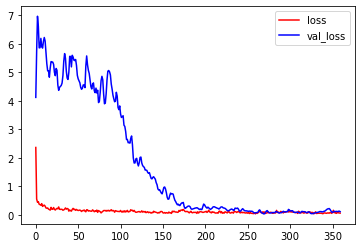

In [11]:
plt.plot(trainHistory.history['loss'], color='r', label='loss')
plt.plot(trainHistory.history['val_loss'], color='b', label='val_loss')
plt.legend()
plt.show()

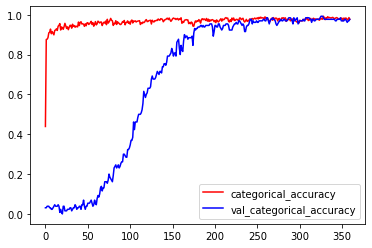

In [12]:
plt.plot(trainHistory.history['categorical_accuracy'], color='r', label='categorical_accuracy')
plt.plot(trainHistory.history['val_categorical_accuracy'], color='b', label='val_categorical_accuracy')
plt.legend()
plt.show()

# Test

In [15]:
best_model = load_model(f"models/{model_tag}/model.h5")

In [16]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(test_dir, shuffle=False, batch_size=130, class_mode="categorical", target_size=(128, 128))
Y_test_classes = np.argmax(test_generator[0][1], 1)

Found 130 images belonging to 26 classes.


In [20]:
loss ,categorical_accuracy = best_model.evaluate(test_generator)
print(f"ACC = {categorical_accuracy * 100:.4f} %")

1/1 [==============================] - 118s 118s/step - loss: 0.1164 - categorical_accuracy: 0.9692
ACC = 96.9231 %


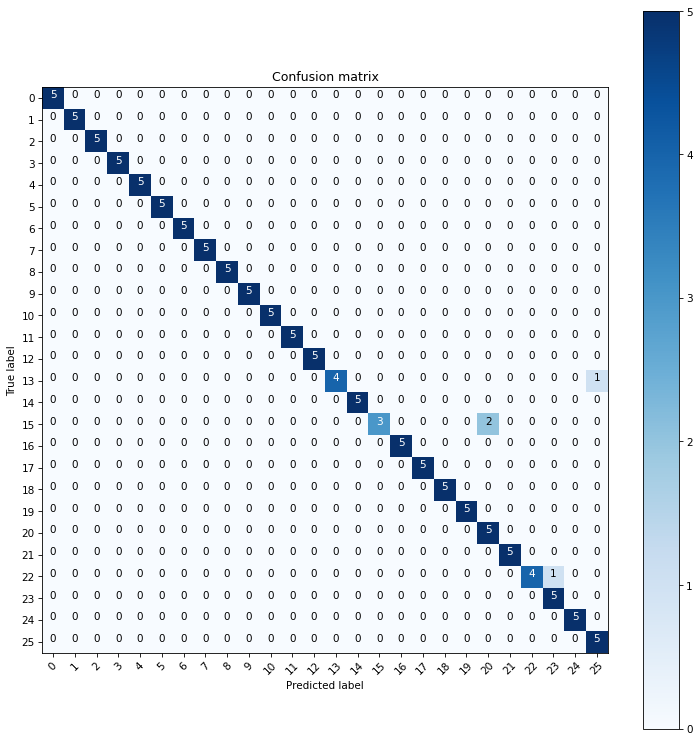

In [21]:
predicts = best_model.predict(test_generator)
predicts_classes = np.argmax(predicts, 1)
utils.plot_confusion_matrix(Y_test_classes, predicts_classes, 26, figsize=(10, 10), dpi=75)

In [19]:
class_dict_data = pd.read_csv("dataset/class_dict.csv")
for i, cls in enumerate(class_dict_data["class"]):
    print(f"{i}. {cls}")

0. baseball
1. basketball
2. beachballs
3. billiard ball
4. bowling ball
5. brass
6. buckeyballs
7. cannon ball
8. cricket ball
9. eyeballs
10. football
11. golf ball
12. marble
13. meat ball
14. medicine ball
15. paint balls
16. pokeman balls
17. puffballs
18. screwballs
19. soccer ball
20. tennis ball
21. tether ball
22. volley ball
23. water polo ball
24. wiffle ball
25. wrecking ball
